In [1]:
import ADerrors as AD
import HDF5
import CairoMakie as CM
import Plots
import StatsPlots
import Statistics as Stats
import CorrelatorAnalysis as CA
using LaTeXStrings

# Colors
colors = CM.Makie.wong_colors();

Read the correlator matrix from the HDF5 file

In [2]:
file_path = "../test/data/correlator_matrix.hdf5"
file = HDF5.h5open(file_path)
corr_matrix = read(file["Correlator Matrix"])
close(file)
Nₜ, N_op, _, N_cnfg = size(corr_matrix)

(33, 3, 3, 1612)

Construct the `uwreal` correlator matrix

In [3]:
mcid = "B450r000"
Cₜ = CA.uwreal_array(corr_matrix, mcid, :auto);

Compute the effective energies of the lowest few states (three in this case) and perform plateau fits to them

In [4]:
aE_eff = CA.GEVP(Cₜ, :ceil_t_half)
CA.err!.(aE_eff)

plateau_range = [15, 24]

# Ground state energy
fit_result = CA.fit_plateau(aE_eff[1], plateau_range, fit_type=:correlated_posdef)
aE0 = CA.err!(fit_result.param[1])

# Energy of first excited state
fit_result = CA.fit_plateau(aE_eff[2], plateau_range, fit_type=:correlated_posdef)
aE1 = CA.err!(fit_result.param[1])

# Energy of second excited state
fit_result = CA.fit_plateau(aE_eff[3], plateau_range, fit_type=:correlated_posdef)
aE2 = CA.err!(fit_result.param[1]);

Plot the result

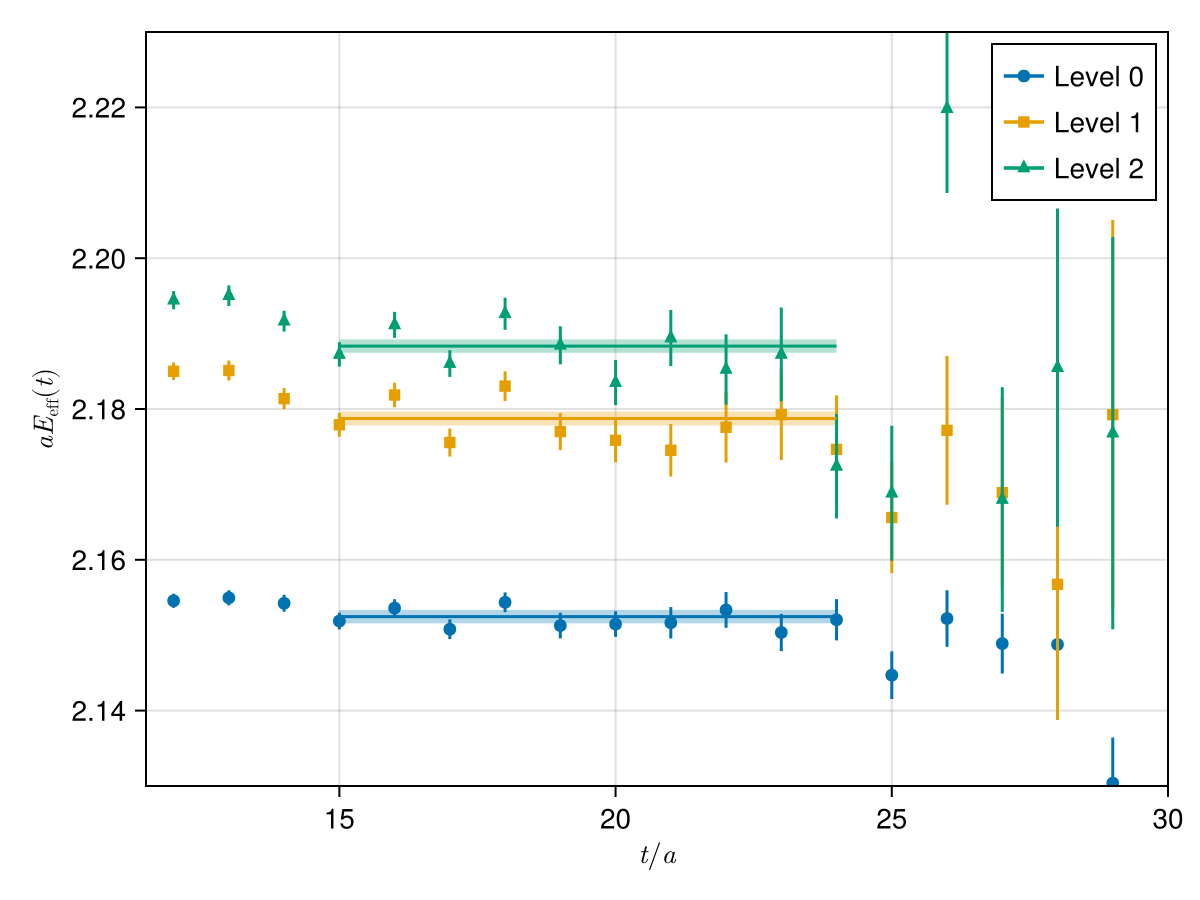

aE0 = 2.1524622389214803 +/- 0.0008896215919601967
aE1 = 2.17874053787349 +/- 0.0009186633907838645
aE2 = 2.1883420746340887 +/- 0.0008906508771061862


In [5]:
f = CM.Figure()
ax = CM.Axis(f[1, 1], limits=(11.5, 30, 2.13, 2.23))

CA.plot_effective_energy!(aE_eff[1], label="Level 0", color=colors[1], marker=:circle)
CA.plot_effective_energy!(aE_eff[2], label="Level 1", color=colors[2], marker=:rect)
CA.plot_effective_energy!(aE_eff[3], label="Level 2", color=colors[3], marker=:utriangle)
CA.plot_error_rectangle!(aE0, plateau_range, color=colors[1])
CA.plot_error_rectangle!(aE1, plateau_range, color=colors[2])
CA.plot_error_rectangle!(aE2, plateau_range, color=colors[3])
CM.axislegend(ax, merge=true)
display(f)

@show aE0
@show aE1
@show aE2;

Analysis of the overlap

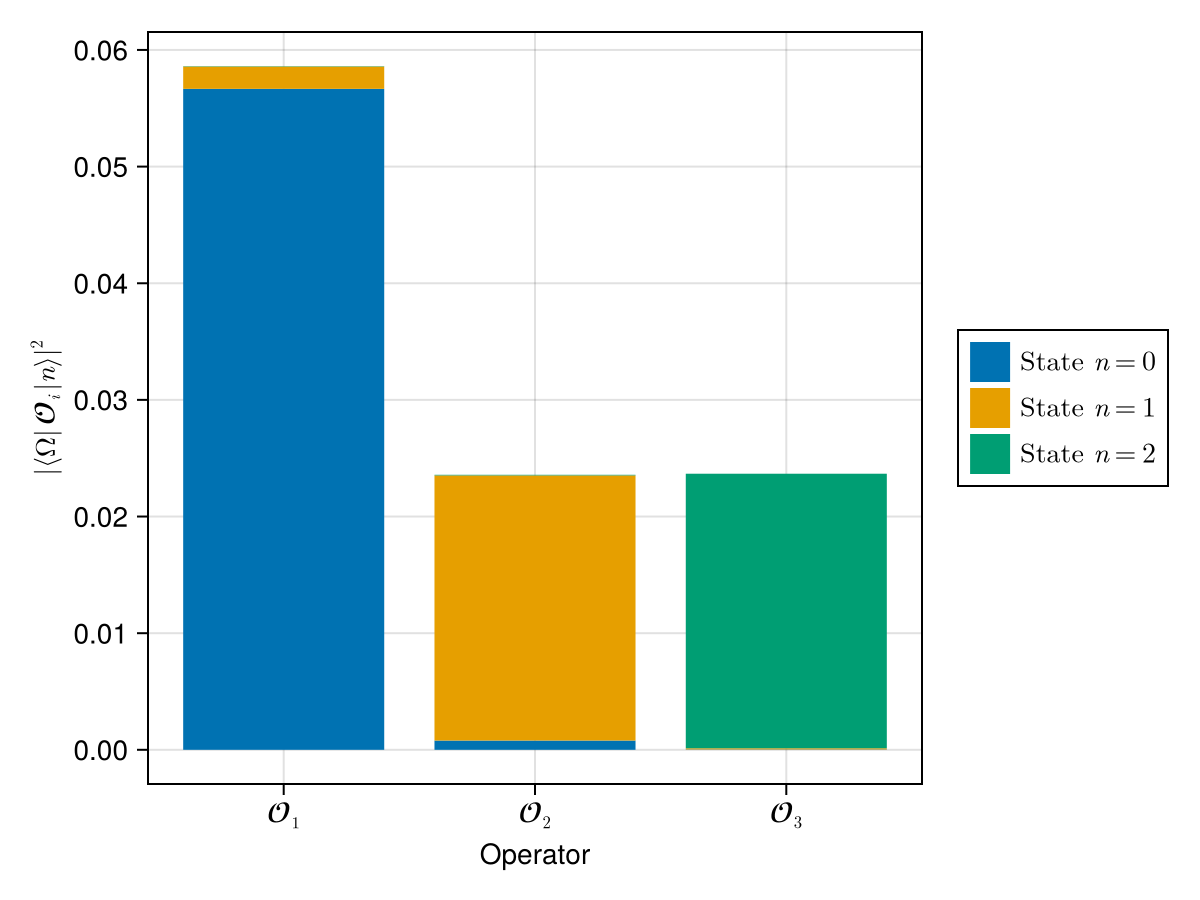

CairoMakie.Screen{IMAGE}


In [11]:
# Specify the time range over which the overlaps are averaged
time_range = [15, 24]

# Compute overlaps of operators with eigenstates of the Hamiltonian
aE_arr = [aE0, aE1, aE2]
Z_in = Stats.mean(CA.overlaps_Z.([Cₜ], [aE_arr], time_range))

# Plot overlaps as histograms
f = CM.Figure()
CA.plot_overlaps!(f, Z_in, n_range=1:3)
CM.axislegend(ax, merge=true)
display(f)